# Read image stack

In [15]:
import imageio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astro3d import image_stack
from tqdm.auto import tqdm

## Settings

We again need to set the printer-specific settings and the directory of the slides:

In [16]:
dpi_x = 600
dpi_y = 300
dz    = 27e-4 # 27 micron
# directory = 'slices_turbulent_box'
directory = 'slices_pluto_color2/'

## Read Images

Get number of files and file dimensions

In [17]:
files = sorted(list(Path(directory).glob('*.png')))
im = imageio.imread(files[0]).transpose(1, 0, 2)
_x = np.arange(im.shape[0])
_y = np.arange(im.shape[1])

dx = 2.54 / dpi_x
dy = 2.54 / dpi_y
dpi_z = 2.54 / dz

Sum up all filled pixels: this counts all pixels, that are not `[255, 255, 255]`, so other than white.

In [18]:
%time summed_image = image_stack.image_sum(files)

CPU times: user 267 ms, sys: 1.02 s, total: 1.28 s
Wall time: 24.1 s


## Print out statistics

In [19]:
print(f'{len(files)} files')
print(f'dimension = {im.shape[0] * dx:.2f} x {im.shape[1] * dy:.2f} x {len(files) * dz:.2f} cm')
print(f'nr of empty pixels: {(summed_image==0).sum() / np.prod(summed_image.shape):.2%}')
print(f'most opaque pixel has {summed_image.max():n} filled pixels (={summed_image.max() / len(files):.2%} of all layers are filled)')

cols = image_stack.check_colors(im)

740 files
dimension = 15.99 x 16.00 x 2.00 cm
nr of empty pixels: 26.24%
most opaque pixel has 89 filled pixels (=12.03% of all layers are filled)
There are 4 colors in this image:
- [29, 85, 111]
- [149, 39, 87]
- [192, 183, 52]
- [255, 255, 255]


Sum up the individual colors

In [20]:
summed = []
for col in tqdm(cols[:-1]):
    summed += [image_stack.image_sum(files, color=col)]
summed = np.array(summed)

  0%|          | 0/3 [00:00<?, ?it/s]

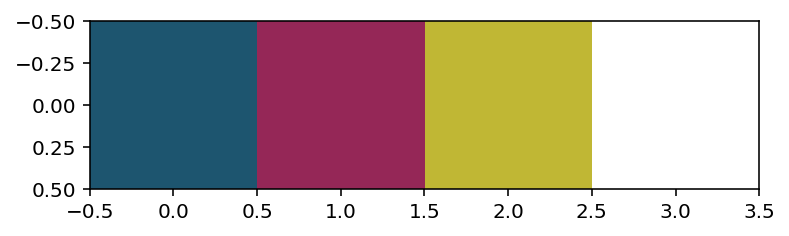

In [21]:
plt.imshow([cols])

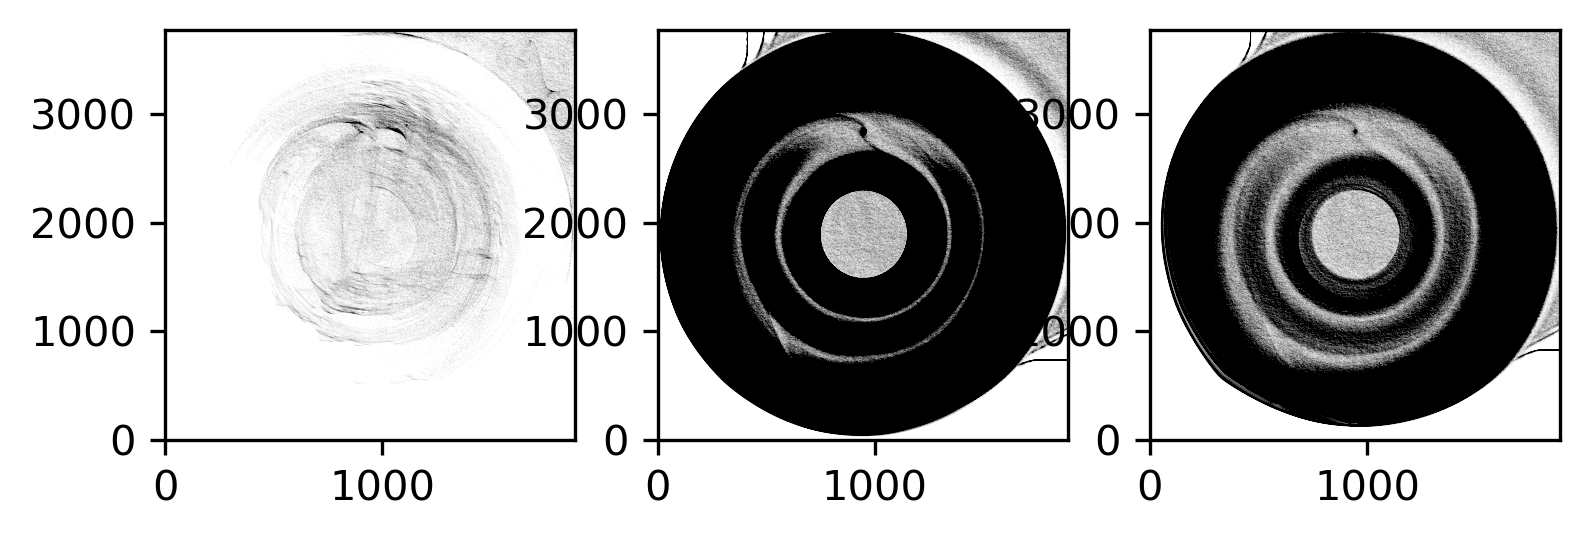

In [22]:
f, ax = plt.subplots(1, len(summed), dpi=150)
for _ax, _im in zip(ax, summed):
    _ax.imshow(_im, origin='lower', vmin=0, vmax=1, cmap='gray_r')
    _ax.set_aspect(dpi_y / dpi_x)

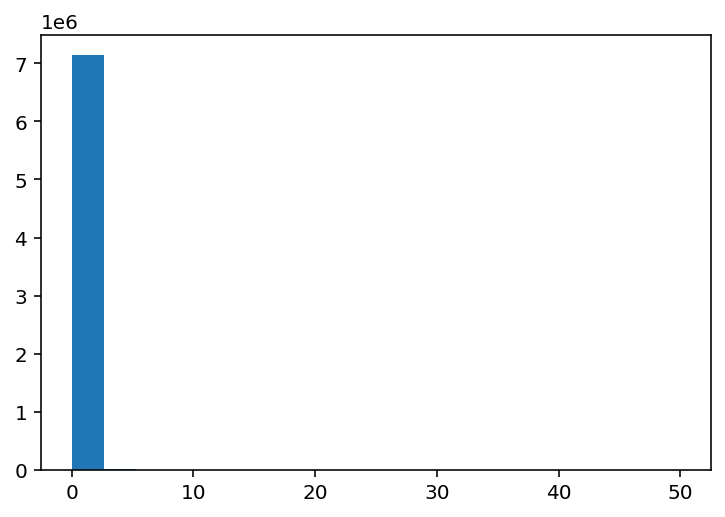

In [23]:
plt.hist(summed[0].ravel(), bins=np.linspace(0,50,20));

## Plots

### Statistics plots
Show fully transparent pixels and the density distribution.

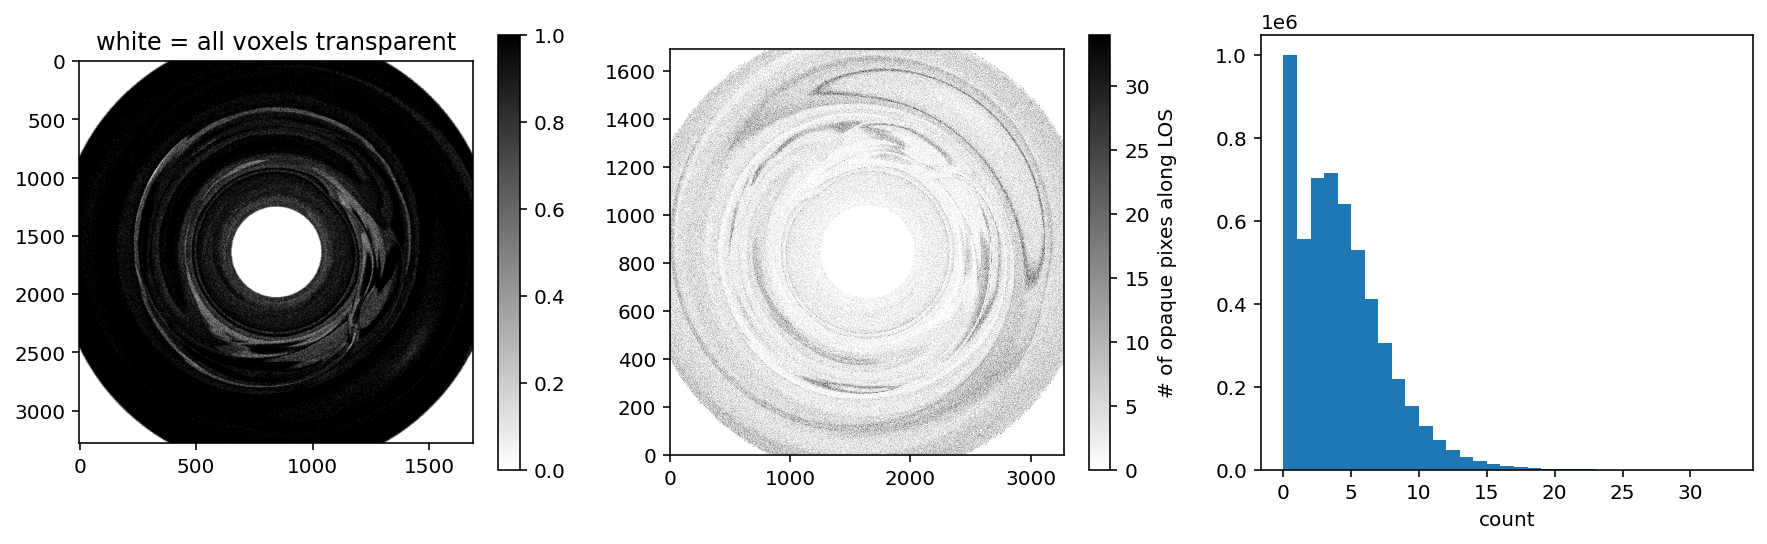

In [6]:
f, axs = plt.subplots(1, 3, figsize=(15, 4))

ax = axs[0]
cc=ax.imshow(summed_image>0, cmap='gray_r')
ax.set_aspect(dpi_y / dpi_x)
plt.colorbar(cc, ax=ax)
ax.set_title('white = all voxels transparent');

ax = axs[1]
ax.set_aspect(dpi_x / dpi_y)
i = ax.pcolormesh(_x, _y, summed_image.T, vmin=0, vmax=summed_image.max(), cmap='gray_r')
cb = plt.colorbar(i, ax=ax)
cb.set_label('# of opaque pixes along LOS')

ax = axs[-1]
counts, bins, patches = ax.hist(summed_image.ravel(), bins=np.arange(summed_image.max()))
ax.set_xlabel('number of filled voxels in column')
ax.set_xlabel('count');

### Compare data to 3d-printed result

In [7]:
slice_width = .1 # in cm
n_slice = int(slice_width / dz)

In [8]:
img = image_stack.image_sum(files[:n_slice])

In [ ]:
f, axs = plt.subplots(1, 3, dpi=200, figsize=(15,5))
axs[0].imshow(img.T / img.max(), cmap='gray_r')
axs[0].set_aspect(dpi_x / dpi_y)
axs[0].set_title(f'sum over first {slice_width:.2f} cm')

axs[1].imshow(imageio.imread('results/img1.jpg'))
axs[1].set_title('45º front illuminated')
axs[2].axis('off')

axs[2].imshow(imageio.imread('results/img2.jpg'))
axs[2].set_title('side illuminated')
axs[2].axis('off');

In [ ]:
from IPython.display import Video
Video('results/turbulent_box.mp4', width=500, html_attributes='autoplay loop')

# Top color

In [ ]:
im = imageio.imread(files[0])

dummyval = 300

im_set = dummyval * np.ones(im.shape, dtype=np.int32)
bg = np.array([255] * 3, dtype=np.int32)
empty = np.array([dummyval] * 3, dtype=np.int32)

for file in tqdm(files):
    im = imageio.imread(file)
    im_set = np.where((np.all(im_set==empty[None, None, :], -1) &  ~np.all(im==bg[None, None, :], -1))[:,:,None], im, im_set)

In [ ]:
f, ax = plt.subplots()
ax.imshow(np.minimum(np.maximum(im_set, 0), 255))
ax.set_aspect(dpi_x / dpi_y);